In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
import os
import cv2
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
# Training Data
data = []
target = []
categories = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
data_dir = r"Training"
for i in categories:
    path = os.path.join(data_dir,i)
    for img in os.listdir(path):
        image_path = os.path.join(path, img)
        image = cv2.imread(image_path,0)
        image = cv2.resize(image, (200,200))
        image = np.array(image).flatten()
        data.append(image)
        target.append(i)


In [3]:
# Testing Data
test_data = []
test_target = []
categories = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
data_dir = r"Testing"
for i in categories:
    path = os.path.join(data_dir,i)
    for img in os.listdir(path):
        image_path = os.path.join(path, img)
        image = cv2.imread(image_path,0)
        image = cv2.resize(image, (200,200))
        image = np.array(image).flatten()
        test_data.append(image)
        test_target.append(i)


In [4]:
X = np.array(data)
y = np.array(target)

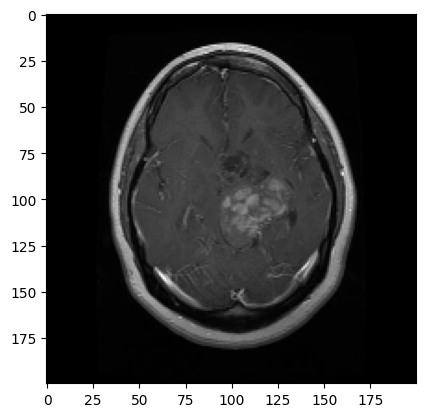

In [5]:
plt.imshow(X[0].reshape(200,200), cmap='gray');

## Split Data
- we want to split the data for training into two sets: training set and dev/validation set

In [116]:
# shuffle the indexing order
np.random.seed(42)
idxs = np.arange(len(X))
np.random.shuffle(idxs)
idxs[:5]

array([ 443, 2394,  761,  651, 2674])

In [134]:
# training data: trianing set, dev set
#                    80%       20%    
n = int(0.9 * len(idxs)) 
idx_train = idxs[:n]
idx_dev = idxs[n:]

X_train = X[idx_train]
X_dev = X[idx_dev]
y_train = y[idx_train]
y_dev = y[idx_dev]

print(X_train.shape)
print(X_dev.shape)

(2583, 40000)
(287, 40000)


In [145]:
d1 = pd.DataFrame([{'a': 5, 'b':6}, {'a':7, 'b': 8}])
d2 = pd.DataFrame([{'a': 20, 'b':66}, {'a':30, 'b': 15}])
pd.concat([d1, d2])

,a,b
0,5,6
1,7,8
0,20,66
1,30,15


In [ ]:
# testing data: which will be used as the final step to evaluate performance
X_test = np.array(test_data)
y_test = np.array(test_target)
print(X_test.shape)

(394, 40000)


## data preprocesssing

In [136]:
# a pixel takes values from 0: full black, to 255: full white. gray levels are in between
print("min pixel value:", X_train.min()) 
print("max pixel value:", X_train.max())

min pixel value: 0
max pixel value: 255


In [137]:
# normalize data to take a value between 0 to 1 using min-max scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)

In [138]:
print("number of features:", X_train.shape[1])

number of features: 40000


In [139]:
# we have a very high number of features, we will use PCA to decrease the number of features while keeping 95% of the information/variation of the data points
pca = PCA(n_components=0.95)
pca_train = pca.fit_transform(X_train_scaled)
pca_dev = pca.transform(X_dev_scaled)

In [140]:
print("number of features before PCA:", X_train_scaled.shape[1])
print("number of features after PCA:", pca_train.shape[1])

number of features before PCA: 40000
number of features after PCA: 856


- wee see that we decreased the number of features by 98%, still keeping 95% of information

## model training

In [ ]:
model1 = LogisticRegression(max_iter=500)
model1.fit(pca_train, y_train)
print("training accuracy:", model1.score(pca_train,y_train))
print("validation accuracy:", model1.score(pca_dev, y_dev))


training accuracy: 1.0
validation accuracy: 0.8536585365853658


In [ ]:
model2 = RandomForestClassifier()
model2.fit(pca_train, y_train)
print("training accuracy:", model2.score(pca_train,y_train))
print("validation accruracy:", model2.score(pca_dev,y_dev))


training accuracy: 1.0
validation accruracy: 0.7700348432055749


In [ ]:
model3 = AdaBoostClassifier()
model3.fit(pca_train, y_train)
print("training accuracy:", model3.score(pca_train,y_train))
print("validation accuracy:", model3.score(pca_dev,y_dev))


training accuracy: 0.6682152535811072
validation accuracy: 0.6411149825783972


- the adaboost classifier underfits the data because it is based on smaller estimators cascaded with decisions based on a small number of features; we have 856 features so the adaboost will not work in this problem

In [ ]:
model4 = SVC()
model4.fit(pca_train, y_train)
print("training accuracy:", model4.score(pca_train,y_train))
print("validation accuracy:", model4.score(pca_dev,y_dev))

training accuracy: 0.9632210607820364
validation accuracy: 0.867595818815331


- the best model so far as for training and validation accuracy is Logistic Regression

In [62]:
model = model1

## Hyperparamter tuning
- our approach is to tune the model hyperparameters to increase the validation set score

In [63]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [64]:
val_score = model.score(pca_dev, y_dev)
print("validation accuracy:",val_score)

validation accuracy: 0.8536585365853658


In [65]:
# increase regularization
model = LogisticRegression(max_iter=500, C=0.20)
model.fit(pca_train, y_train)
print("validation accuracy after:", model.score(pca_dev, y_dev))

validation accuracy after: 0.8501742160278746


In [66]:
# increase number of iterations
model = LogisticRegression(max_iter=10000)
model.fit(pca_train, y_train)
print("validation accuracy:", model.score(pca_dev, y_dev))

validation accuracy: 0.8536585365853658


- it seems we can't further improve our model, we will switch to more flexibile model: RandomForest

In [67]:
model = RandomForestClassifier()
model.fit(pca_train, y_train)
print("training accuracy:", model.score(pca_train,y_train))
print("validation accruracy:", model.score(pca_dev,y_dev))


training accuracy: 1.0
validation accruracy: 0.7630662020905923


In [68]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [69]:
grid_space = [
    {"max_depth": [3,10,15], "n_estimators": [50, 100, 200]}
]

clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_space)
clf.fit(pca_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [3, 10, 15],
                          'n_estimators': [50, 100, 200]}])

In [70]:
clf.score(pca_dev, y_dev)

0.7700348432055749

- not increasing much, lastly let's try optimizing: SupportVectorClassifier

In [72]:
model = SVC()
model.fit(pca_train, y_train)
print("training accuracy:", model.score(pca_train,y_train))
print("validation accuracy:", model.score(pca_dev,y_dev))

training accuracy: 0.9632210607820364
validation accuracy: 0.867595818815331


In [73]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [74]:
grid_space = [
    {"C": [0.1,1,10], "kernel": ["rbf","poly"], "gamma": [1,0.1]}
]
clf = GridSearchCV(estimator=SVC(), param_grid=grid_space)
clf.fit(pca_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10], 'gamma': [1, 0.1],
                          'kernel': ['rbf', 'poly']}])

In [75]:
clf.score(pca_dev, y_dev)

0.8815331010452961

In [131]:
# these are the best paramaters found for training score
clf.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}

In [141]:
# will optimize more for validation
model = SVC(C=0.1, gamma=1, kernel='poly')
model.fit(pca_train, y_train)
print("training accuracy:", model.score(pca_train,y_train))
print("validation accuracy:", model.score(pca_dev,y_dev))

training accuracy: 1.0
validation accuracy: 0.8815331010452961


this is the best model so far with 88% accuracy on validation set.

## accraucy on testing

In [142]:
# preprocessing
X_test_scaled = scaler.transform(X_test)
pca_test = pca.transform(X_test_scaled)

In [143]:
print("testing accuracy:", model.score(pca_test,y_test))

testing accuracy: 0.7766497461928934


In [150]:
# let's combine all the dataset
pca_comb = np.vstack([pca_train, pca_dev, pca_test])
y_comb = np.hstack([y_train, y_dev, y_test])
print(pca_comb.shape, y_comb.shape)
model.fit(pca_comb, y_comb)
model.score(pca_comb, y_comb)

(3264, 856) (3264,)


1.0

In [154]:
# let's check other metrics, precision, recall
y_pred = model1.predict(pca_comb)
cm = confusion_matrix(y_comb, y_pred)
cm

array([[846,  27,  43,  10],
       [ 14, 910,  11,   2],
       [  5,   5, 483,   7],
       [  3,  15,   7, 876]], dtype=int64)

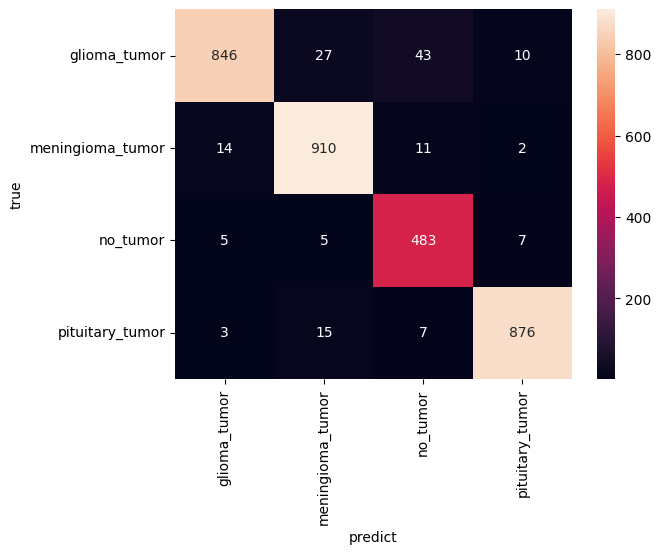

In [155]:
sns.heatmap(cm,annot=True, fmt='g', xticklabels=categories, yticklabels=categories)
plt.xlabel("predict")
plt.ylabel("true");

In [172]:
avg_precision = precision_score(y_comb, y_pred,  average='micro')
avg_recall = recall_score(y_comb, y_pred, average='micro')
print("average precision:", avg_precision)
print("average recall:", avg_recall)

average precision: 0.9543504901960784
average recall: 0.9543504901960784


### review on precision and recall
the main goal of training a machine learning model is to get highest possible accuracy. after accuracy there are other metrics we should be careful with depending on our problem. 
#### Precision
Precision is how reliable our predictions are, the higher the precision, the less non-correct labels predicted as correct.
#### Recall
The higher the recall, the less correct labels predicted as incorrect.

We assume that our model will be used in the initial scanning, so our focus is on people that actually have cancer and did the scanning, even if there was a tiny chance a person could have cancer, we will be assume he has. This will make some people that are healthy predicted wrong, but in our case this is okay, since there are usually there will be more advanced scans coming next to make sure they are sick.

So recall is more important than precision in our case.

In [ ]:
# Calculating the metrics for each category ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
predicted_spaces = cm.sum(axis=0)
true_spaces = cm.sum(axis=1)
correct_counts = cm[[0,1,2,3], [0,1,2,3]]

recalls = correct_counts / true_spaces
precisions = correct_counts / predicted_spaces

metrics = pd.DataFrame({'Recall': recalls, 'Precision': precisions} , index=["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"])
metrics

,Recall,Precision
glioma_tumor,0.913607,0.974654
meningioma_tumor,0.971185,0.950888
no_tumor,0.966000,0.887868
pituitary_tumor,0.972253,0.978771


## glioma_tumor
We see that we get a high recall (i.e. 91%) but precision is quite high (97%), this is suggesting that the model is priotizing precision over recall in that case which is not favourable.

## no_tumor
In no_tumor the recall is quiet higher than precision (97% > 89%), we said we priotize recall, but in case of no-tumor we should priotize precision, we want to be quiet certain before saying anyone is healthy, the consequences of wrong results are fatal.

## meningioma_tumor, pituitary_tumor
Recall is quiet high in both cases, which is favourable.